# **N1. Data Exploration**

Notebook focused on analyzing the dataset provided by the Metis Solar Orbiter.

**Load libraries**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import matplotlib as mpl
from astropy.io import fits
import numpy as np
from libraries.utilities import*

# Plotting configuration.
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["mathtext.fontset"] = "cm"  

from matplotlib.colors import LogNorm

## 1. Introduction

### 1.1. Data products

For this project, the data provided by the Solar Orbiter Archive consists on a set of FITS (Flexible image transport system) which are store in the repository. Files are divided into the following classes:

1. Visible Light channel:
    - Polarized-brightness sequences.
    - Total-brightness images.
    - Fixed-polarization images.
    - Light Curves.
2. UV channel:
    - Analog-mode acquisitions.
    - Photon-counting acquisitions.
    - Offset maps.
3. Both:
    - Temporal noise acquisitions.
    - Cosmic-ray and SEP log matrices.

A detailed description of each data product may be found in the official website. As the main objective is to detect objects in a given image, from now on, only images in the visible light range and ultraviolet range will be taken into account.

### 1.2 Levels.
Obtained FITS files are categorized according to the level of processing as follows:

- Level 0: uncalibrated images packed in standard FITS format. 
- Level 1: uncalibrated images that contain extra engineering data.
- Level 2: calibrated data in physical units. Corrections are aplied such as: bias, dark-current, flat-flied, vignetting among others. Coordinates are expressed in scientific coordinate systems (WCS)
- Level 3: data from L2 files with extra scientific analysis.

On the previously mentioned repository, only data from L2 are shown. L0 data was collected later using a package develop that will be explained later. L1 will not be taken into account.

### 1.3 Structure.
Data is stored in LTPs (long-term-planning) with corresponding STPs (short-term-planning). Inside each STP folder, a set of different FITS files may be found.

LTPs values goes from 5 to 17 and STP values from 168 to 340. This configuration represents data acquisition from 2022. It follows the following schema:

        LTP5: STP168, STP169, STP170 ... STP 182

        LTP6: STP 183, STP184, ... STP197

        ...

        LTP17: STP328, ... STP340

**The data size can be seen in the following plot:**

In [2]:
# Folder with sources.
DATA_FOLDER = "resources"
# Load .csv with dataset size.
metis_all = pd.read_csv(os.path.join(DATA_FOLDER, "dataset_structure_all.csv")).drop(columns = "Unnamed: 0")
dataset_size = metis_all.groupby("LTP")["FN"].sum().sum()
metis_vl = pd.read_csv(os.path.join(DATA_FOLDER, "dataset_structure_vl.csv")).drop(columns = "Unnamed: 0")
dataset_size_vl = metis_vl.groupby("LTP")["FN"].sum().sum()
metis_uv = pd.read_csv(os.path.join(DATA_FOLDER, "dataset_structure_uv.csv")).drop(columns = "Unnamed: 0")
dataset_size_uv = metis_uv.groupby("LTP")["FN"].sum().sum()

# Create dataframes.
series_vl = pd.DataFrame(metis_vl.groupby("LTP")["FN"].sum())
series_all = pd.DataFrame(metis_all.groupby("LTP")["FN"].sum())
series_uv = pd.DataFrame(metis_uv.groupby("LTP")["FN"].sum())


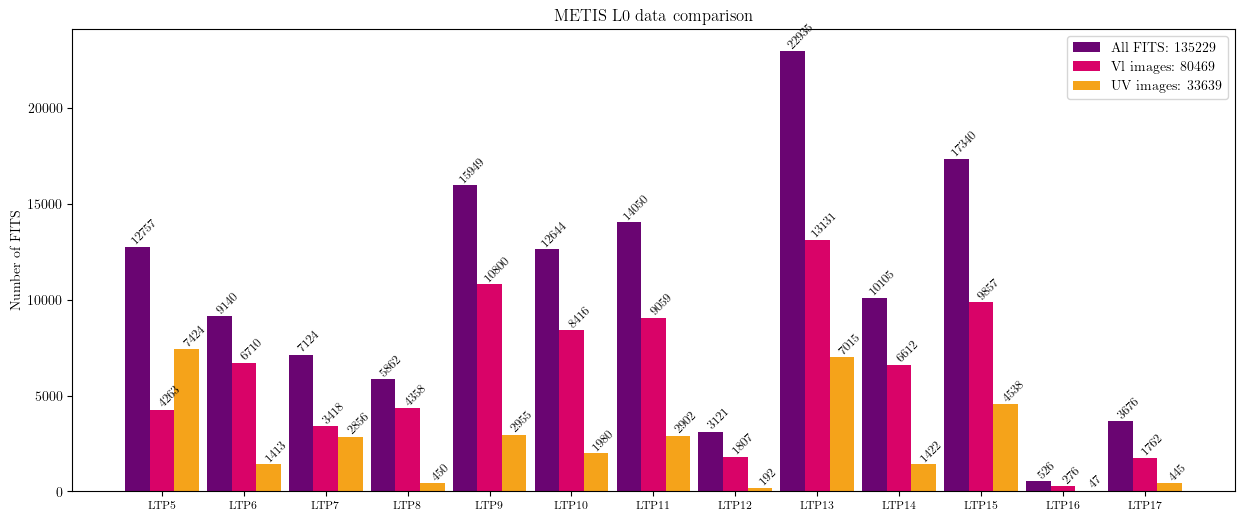

In [3]:

# Call figure
plt.figure(figsize = (15,6))
plt.xticks(fontsize = 8)
plt.ylabel("Number of FITS")
plt.title(f"METIS L0 data comparison", fontweight = "bold")

bar_width = 0.3
positions = range(len(series_all))
ticks = np.arange(13)

plt.bar(x=[p - bar_width for p in positions], height= series_all["FN"], width= bar_width, color = "#6a0572", label = f"All FITS: {dataset_size}")
plt.bar( x=positions, height= series_vl["FN"], width= bar_width, color = "#d90368", label = f"Vl images: {dataset_size_vl}")
plt.bar( x=[p + bar_width for p in positions], height= series_uv["FN"],width= bar_width, color = "#f5a31a", label =f"UV images: {dataset_size_uv}")
plt.legend()
plt.xticks(ticks = ticks, labels = ["LTP5", "LTP6", "LTP7", "LTP8", "LTP9", "LTP10", "LTP11", "LTP12", "LTP13", "LTP14", "LTP15", "LTP16", "LTP17"]);

for idx in positions:
    plt.text(idx - bar_width + 0.1, series_all["FN"].iloc[idx] + 0.5, str(series_all["FN"].iloc[idx]), ha="center",
              va="bottom", rotation = 45, fontsize = 9)
    plt.text(idx + 0.1, series_vl["FN"].iloc[idx] + 0.5, str(series_vl["FN"].iloc[idx]), ha="center",
              va="bottom", rotation = 45, fontsize = 9)
    plt.text(idx + bar_width + 0.1, series_uv["FN"].iloc[idx] + 0.5, str(series_uv["FN"].iloc[idx]), ha="center",
              va="bottom", rotation = 45, fontsize = 9)

## 2. Data Downloading for L0 images.

In order to obtain the whole dataset it was developed a package that retrieves all L0 FITS. The pipeline is the following:

1. Using two  previously defined APIs, retrieve the LTPs and STPs labels.
2. Create folders for each one and extract the headers of each file inside every STP folder.
3. Merge the headers of a file for obtaining its url to the server.
4. Download the content and save it into the folders.
5. Create a .csv for files that could not be downloaded.

Additionally, it is possible to download a specific kind of FITS file, for example: vl-image, or uv-image.

**For installing it, run the following commands:**
1. Clone the repository:
   ```bash
   git clone git@github.com:chioettop/metis_archive_synch.git
   cd metis_archive_synch
2. Install dependencies:
   ```bash
   pip install -r requirements.txt
3. Run it
   ```bash
   python metisdownloader.py

## 3. L0 Files

### 3.1. Visible light

Let's analyze the components of FITS L0 image in the visible light bandwidth. It is formed by two files, one with the image and the other one a bin table.


In [4]:
# Load image
L0_file = os.path.join("resources", "solo_L0_metis-vl-image_0726041008_V01.fits")
L0 = fits.open(L0_file)
# Display components.
L0

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x78f3be83a800>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x78f3be2d2170>]

#### 3.1.1. Headers

For this project, just the first component will be taken into account, which is the one that has the image. Let's analyze the headers.

In [5]:
L0[0].header

SIMPLE  =                    T / file comforms to FITS standard                 
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =                 2048 / length of data axis 2                          
EXTEND  =                    T / FITS file contains extensions                  
LONGSTRN= 'OGIP 1.0'           / FITS header contains long strings              
FILENAME= 'solo_L0_metis-vl-image_0726041008_V01.fits' / FITS filename          
FILE_RAW= '2023-01-03T06.33.25.962458Z-VL_IMAGE.raw' / filename of raw data     
APID    =                 1084 / APID number of associated telemetry            
OBT_BEG =    726041008.2422638 / start acquisition time in OBT                  
OBT_END =    726042639.9970703 / end acquisition time in OBT                    
LEVEL   = 'L0      '        

The most important parameters are:
- NAXIS1: the size of the file in the x axis, in this case 2048 pixels.
- FILENAME: the filename and product. In this case is an image in the visible light range.
- FILERAW: has the data where the FITS was taken.
- LEVEL: the preprocessing that the image has, in this case it is the raw version.

#### 3.1.2. Image
Now let's plot the image.

Text(0, 0.5, 'y detector')

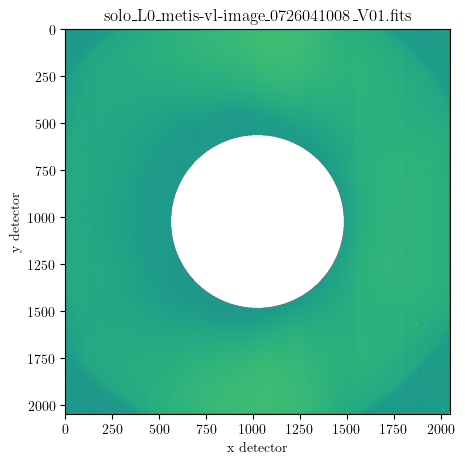

In [6]:
fig, axis = plt.subplots(1, 1, figsize = (5, 5))
axis.imshow(L0[0].data, cmap = "viridis", norm = LogNorm())
axis.set_title(L0[0].header["FILENAME"])
axis.set_xlabel("x detector")
axis.set_ylabel("y detector")


In this image a few things can be seen:
1. The dark spot in the center is the plate that protects the sensors onboard the metis from the sun rays.
2. In the corners, due to vignetting, it is possible to see the reduction in the brightness of the image.
3. Possible stars in the image are not fully visible due to the lack of preprocessing.

### 3.2 Ultraviolet band

Let's analyze the components of FITS L0 image in the ultraviolet bandwidth. It is formed by two files, one with the image and the other one a bin table.

In [7]:
# Load image
L0_file = os.path.join("resources", "solo_l0_metis-uv-image_0658803566_v01.fits")
L0 = fits.open(L0_file)
# Display components.
L0

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x78f3be2d2140>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x78f3be602800>]

#### 3.2.1. Headers

And headers are:

In [8]:
L0[0].header

SIMPLE  =                    T /  File conforms to FITS standard                
BITPIX  =                   16 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 1024 / Number of pixels along axis 1                  
NAXIS2  =                 1024 / Number of pixels along axis 2                  
EXTEND  =                    T /  File may contain extensions                   
LONGSTRN= 'OGIP 1.0'           / FITS header contains long strings              
FILENAME= 'solo_l0_metis-uv-image_0658803566_v01.fits' / FITS filename          
FILE_RAW= '2020-11-16T01.02.50.432893Z-UV_IMAGE.raw' / Filename of raw data     
APID    =                 1084 / APID number of associated telemetry            
OBT_BEG =      658803566.73457 / Start acquisition time in on-board time        
OBT_END =      658803726.42957 / End acquisition time in on-board time          
LEVEL   = 'L0      '        

The most important parameters are the same listed for the image acquired in the visible light.

#### 3.2.2. Image

Text(0, 0.5, 'y detector')

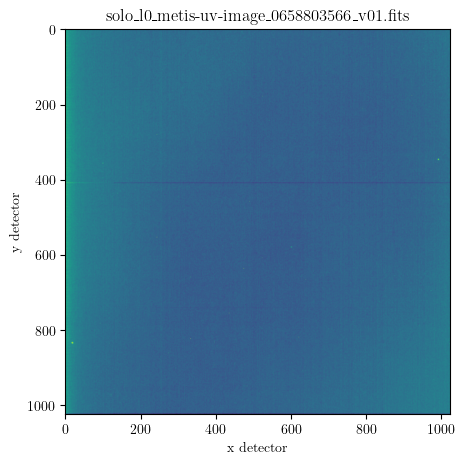

In [9]:
fig, axis = plt.subplots(1, 1, figsize = (5, 5))
axis.imshow(L0[0].data, cmap = "viridis", norm = LogNorm())
axis.set_title(L0[0].header["FILENAME"])
axis.set_xlabel("x detector")
axis.set_ylabel("y detector")

In this case, there is no visible dark spot for the metis plate that protects against direct solar light. We could also see two interesting points that could be stars or other objects.

## 4. L2 Files

### 4.1. Visible light

As it was mentioned before, an L2 image has layers of corrections and processing which enhances the image. The contents are:

In [10]:
L2_file = os.path.join("resources", "solo_L2_metis-vl-image_20230103T060601_V01.fits")
L2 = fits.open(L2_file)
L2

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x78f3be2d2440>, <astropy.io.fits.hdu.image.ImageHDU object at 0x78f3be6ad210>, <astropy.io.fits.hdu.image.ImageHDU object at 0x78f3be6ad570>]

Here we have, three file images.

#### 4.1.1 Headers
Headers of the first image are:

In [11]:
L2[0].header

SIMPLE  =                    T / file comforms to FITS standard                 
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
EXTEND  =                    T / FITS file contains extensions                  
LONGSTRN= 'OGIP 1.0'           / FITS header contains long strings              
FILENAME= 'solo_L2_metis-vl-image_20230103T060601_V01.fits' / FITS filename     
FILE_RAW= '2023-01-03T06.33.25.962458Z-VL_IMAGE.raw' / filename of raw data     
PARENT  = 'solo_L1_metis-vl-image_20230103T060601_V01.fits' / name of the parent
APID    =                 1084 / APID number of associated telemetry            
DATE    = '2023-01-12T14:19:58.75' / date and time of FITS file creation        
DATE-OBS= '2023-01-03T06:06:

Most relevant headers are:
- NAXIS1: The size of the file, in this case 1024 x 1024 pixels.
- DATE-OBS: Date where observation started.
- DATE-END: Date where observation ended.
- WAVELNTH: Characteristic waveband used. Additionally there's info about the wavelengths used as bandpass (min, max).

Other important parameters can be: Position information in different reference frameworks, acquisition time, parameters for corrections, among others.


Header of second image are:

In [12]:
L2[1].header

XTENSION= 'IMAGE   '           / image extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
PCOUNT  =                    0 / parameter count                                
GCOUNT  =                    1 / group count                                    
EXTNAME = 'Quality matrix'     / extension name                                 
LONGSTRN= 'OGIP 1.0'           / FITS header contains long strings              
FILENAME= 'solo_L2_metis-vl-image_20230103T060601_V01.fits' / FITS filename     
FILE_RAW= '2023-01-03T06.33.25.962458Z-VL_IMAGE.raw' / filename of raw data     
PARENT  = 'solo_L1_metis-vl-image_20230103T060601_V01.fits' / name of the parent
APID    =                 10

Headers of third image are:

In [13]:
L2[2].header

XTENSION= 'IMAGE   '           / image extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
PCOUNT  =                    0 / parameter count                                
GCOUNT  =                    1 / group count                                    
EXTNAME = 'Error matrix'       / extension name                                 
LONGSTRN= 'OGIP 1.0'           / FITS header contains long strings              
FILENAME= 'solo_L2_metis-vl-image_20230103T060601_V01.fits' / FITS filename     
FILE_RAW= '2023-01-03T06.33.25.962458Z-VL_IMAGE.raw' / filename of raw data     
PARENT  = 'solo_L1_metis-vl-image_20230103T060601_V01.fits' / name of the parent
APID    =                 10

#### 4.1.2. Images
The three images in the file are:

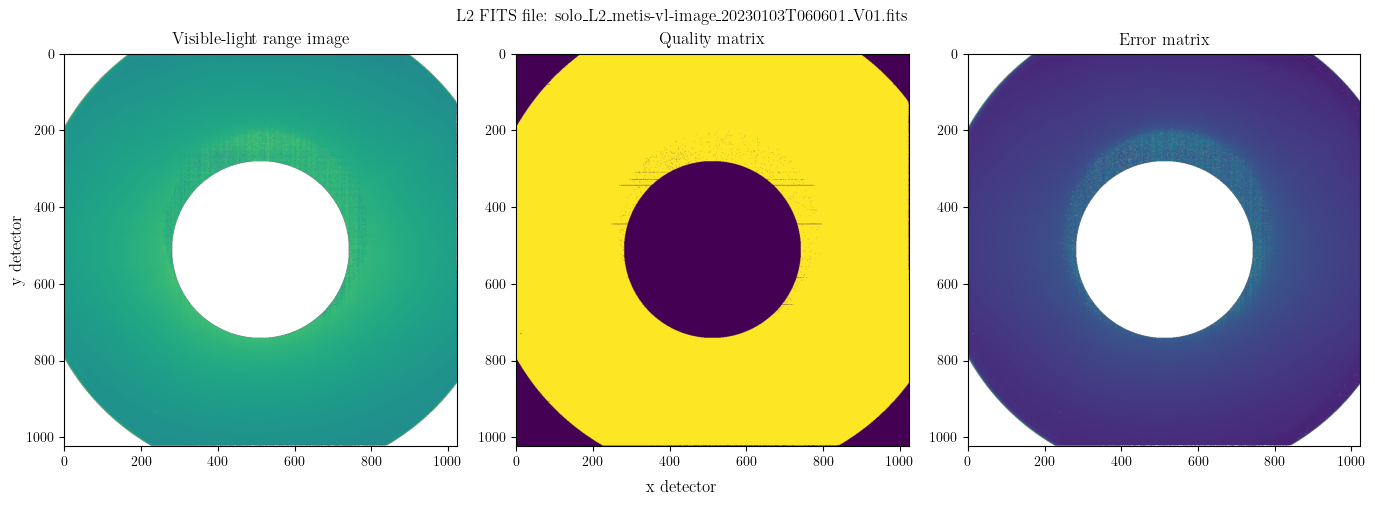

In [14]:
fig, axis =  plt.subplots(1, 3, figsize = (14, 5))
fig.supxlabel("x detector")
fig.supylabel("y detector")
fig.suptitle(f"L2 FITS file: {L2[0].header['FILENAME']}")

axis[0].imshow(L2[0].data, norm = LogNorm() )
axis[0].set_title("Visible-light range image")
axis[1].imshow(L2[1].data )
axis[1].set_title("Quality matrix")
axis[2].imshow(L2[2].data, norm = LogNorm() )
axis[2].set_title("Error matrix")
plt.tight_layout() 

Labels were extracted in the header called: "extension". Here we will only focus on the image itself and not in the quality matrix or the error matrix.

### 4.2 Ultraviolet bandwidth

The FITS L2 in the uv range is:

In [15]:
L2_file = os.path.join("resources", "solo_L2_metis-uv-image_20240101T060007_V01.fits")
L2 = fits.open(L2_file)
# Display components.
L2

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x78f3be6ad2d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x78f3be461db0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x78f3be462110>]

Here we also have three images.

#### 4.2.1. Headers

The headers are:

For the first image:

In [16]:
L2[0].header

SIMPLE  =                    T / file comforms to FITS standard                 
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
EXTEND  =                    T / FITS file contains extensions                  
LONGSTRN= 'OGIP 1.0'           / FITS header contains long strings              
FILENAME= 'solo_L2_metis-uv-image_20240101T060007_V01.fits' / FITS filename     
FILE_RAW= '2024-01-01T06.07.26.092725Z-UV_IMAGE.raw' / filename of raw data     
PARENT  = 'solo_L1_metis-uv-image_20240101T060007_V01.fits' / name of the parent
APID    =                 1084 / APID number of associated telemetry            
DATE    = '2024-02-08T03:19:17.96' / date and time of FITS file creation        
DATE-OBS= '2024-01-01T06:00:

For the second one:

In [17]:
L2[1].header

XTENSION= 'IMAGE   '           / image extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
PCOUNT  =                    0 / parameter count                                
GCOUNT  =                    1 / group count                                    
EXTNAME = 'Quality matrix'     / extension name                                 
LONGSTRN= 'OGIP 1.0'           / FITS header contains long strings              
FILENAME= 'solo_L2_metis-uv-image_20240101T060007_V01.fits' / FITS filename     
FILE_RAW= '2024-01-01T06.07.26.092725Z-UV_IMAGE.raw' / filename of raw data     
PARENT  = 'solo_L1_metis-uv-image_20240101T060007_V01.fits' / name of the parent
APID    =                 10

For the last image:

In [18]:
L2[2].header

XTENSION= 'IMAGE   '           / image extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
PCOUNT  =                    0 / parameter count                                
GCOUNT  =                    1 / group count                                    
EXTNAME = 'Error matrix'       / extension name                                 
LONGSTRN= 'OGIP 1.0'           / FITS header contains long strings              
FILENAME= 'solo_L2_metis-uv-image_20240101T060007_V01.fits' / FITS filename     
FILE_RAW= '2024-01-01T06.07.26.092725Z-UV_IMAGE.raw' / filename of raw data     
PARENT  = 'solo_L1_metis-uv-image_20240101T060007_V01.fits' / name of the parent
APID    =                 10

#### 4.2.2. Images

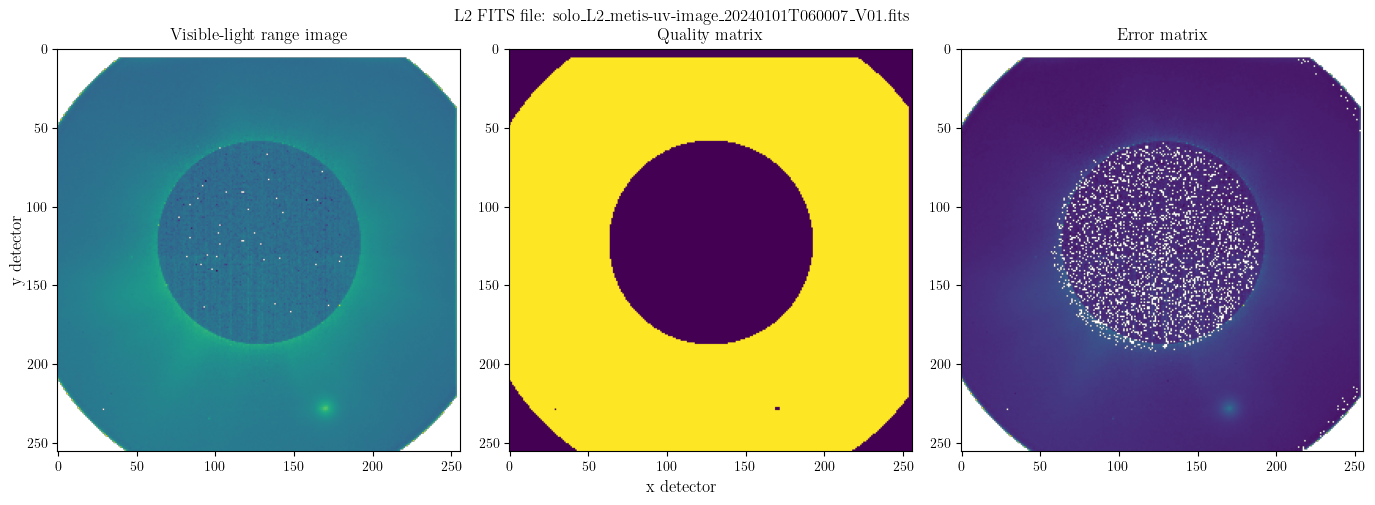

In [19]:
fig, axis =  plt.subplots(1, 3, figsize = (14, 5))
fig.supxlabel("x detector")
fig.supylabel("y detector")
fig.suptitle(f"L2 FITS file: {L2[0].header['FILENAME']}")

axis[0].imshow(L2[0].data, norm = LogNorm() )
axis[0].set_title("Visible-light range image")
axis[1].imshow(L2[1].data )
axis[1].set_title("Quality matrix")
axis[2].imshow(L2[2].data, norm = LogNorm() )
axis[2].set_title("Error matrix")
plt.tight_layout() 

## 5. Comparison

Let's look closer between another set of L0 and L2 images from the same timestamp.

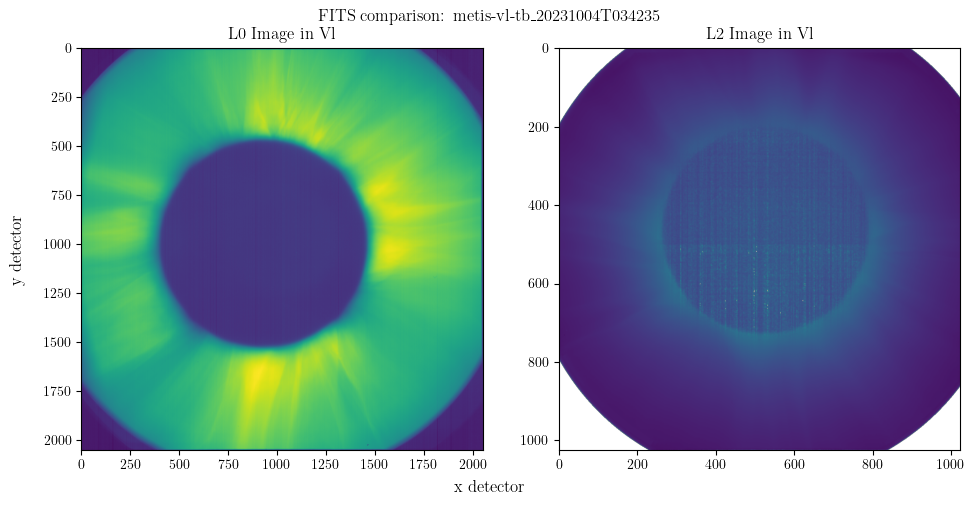

In [20]:
L0_A = fits.open(os.path.join("resources", "solo_L0_metis-vl-image_0749705834_V01.fits"))
L2_A = fits.open(os.path.join("resources", "solo_L2_metis-vl-tb_20231004T034235_V01.fits"))

fig, axis = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle(f"FITS comparison: {L2_A[0].header['FILENAME'][8:35]}")
fig.supxlabel("x detector")
fig.supylabel("y detector")

axis[0].imshow(L0_A[0].data, norm = LogNorm())
axis[0].set_title("L0 Image in Vl")
axis[1].imshow(L2_A[0].data, norm = LogNorm())
axis[1].set_title("L2 Image in Vl")


plt.tight_layout()

Even though L2 files are more suitable to object detection due to the previous corrections applied, L0 images will be consider first for the Neural Network training. The expected time for obtaining an L2 image may be considerably large therefore it is better to work with L0. In the next steps, corrections may be also applied to the L0 image in order to improve classification and detection.

## 6. L0 headers.

Headers can be downloaded separately from the database server without the needing to download the image itself. Then, it is possible to do a preliminary analysis.

In [21]:
# Path-to-headers.
PATH_HEADERS_L0 = "resources/metis_all25022025151324.pkl"
headers_l0 = pd.DataFrame(pd.read_pickle(PATH_HEADERS_L0))
print(F"Total files: {len(headers_l0)}, number of headers: {len(headers_l0.columns)}")

Total files: 152455, number of headers: 136


In [22]:
headers_l0.groupby("orig_x").count()

,id,filename,filepath,file_raw,created,date_obs_start,pubblication_time,obt_end,obt_beg,compress,...,ttype1,ttype2,datamin,datamax,width,height,stp,filter,ltp,url
orig_x,,,,,,,,,,,,,,,,,,,,,
1024.0,31653,31653,31653,31653,31653,31653,31653,31653,31653,31653,...,31653,31653,31653,31653,31653,31653,31653,31653,31653,31653
2048.0,78277,78277,78277,78277,78277,78277,78277,78277,78277,78277,...,78277,78277,78277,78277,78277,78277,78277,78277,78277,78277
6496.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [23]:
# Display columns.
print(headers_l0.columns.tolist())

['id', 'filename', 'filepath', 'file_raw', 'created', 'date_obs_start', 'pubblication_time', 'obt_end', 'obt_beg', 'compress', 'comp_rat', 'hdr_vers', 'datatype', 'obj_cnt', 'conf_id', 'sess_num', 'bin_type', 'compr', 'radial', 'cadence', 'cad_beg', 'cad_end', 'apid', 'masking', 'maskrmin', 'maskrmax', 'level', 'origin', 'creator', 'vers_sw', 'version', 'history', 'comment', 'tsensor', 'x_size', 'y_size', 'z_size', 'p_bands', 'n_bands', 'orig_x', 'orig_y', 'firstrow', 'b0_bin', 'b0_dq', 'b0_stop', 'b1_bin', 'b1_dq', 'b1_stop', 'b2_bin', 'b2_dq', 'b2_stop', 'n', 'pol_id', 'measkind', 'framemod', 'vlfpfilt', 'cr_sep', 'cme_obs', 'sundisk', 'sp_noise', 'pmpstab', 'ref_rows', 'ndit', 'snrmin', 'snrmax', 'dac1pol1', 'dac1pol2', 'dac1pol3', 'dac1pol4', 'dac2pol1', 'dac2pol2', 'dac2pol3', 'dac2pol4', 'pmptemp', 'nb_img', 'cr_sep_a', 'cr_sep_b', 'dit', 'n_pol', 'seq_num', 'sn_mean1', 'sn_var1', 'sn_mean2', 'sn_var2', 'sn_mean3', 'sn_var3', 'sn_mean4', 'sn_var4', 'sn_mean5', 'sn_var5', 'presum'

### 6.1. Headers analysis.

#### 6.1.1. Acquisition time

(Text(0.5, 0, 'Minutes'), Text(0, 0.5, 'Number of FITS'))

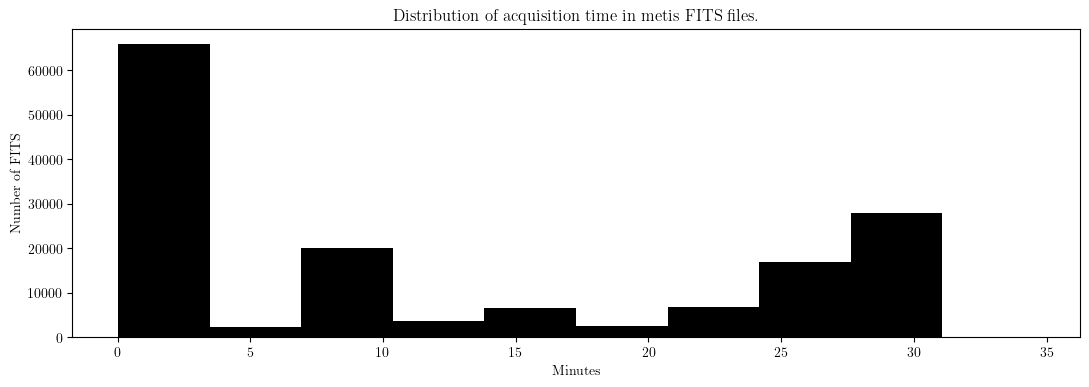

In [24]:
# Compute acquisition time.
headers_l0["acquisition time"] = headers_l0.apply(lambda x: x["obt_end"] - x["obt_beg"], axis = 1)
# Convert into minutes.
acq_time = headers_l0["acquisition time"].apply(lambda x: x/60).to_list()

fig, axis = plt.subplots(1, 1, figsize= (13, 4))
axis.hist(acq_time, color = "black")
axis.set_title("Distribution of acquisition time in metis FITS files.")
axis.set_xlabel("Minutes"), axis.set_ylabel("Number of FITS")

Most FITS files have 1 minute of acquisition time.

#### 6.1.2. Datatype

In [25]:
# Create new column from the "file raw" column and extract the datatype
headers_l0["datapack"] = headers_l0["file_raw"].apply(lambda x: x[-12:-4])

# Count the number of datapacks.
data_packs = headers_l0.groupby("datapack").count()["id"].to_dict()
labels = list(data_packs.keys())
counts = list(data_packs.values())

[Text(0, 0, '12'),
 Text(0, 0, '18807'),
 Text(0, 0, '36682'),
 Text(0, 0, '93097'),
 Text(0, 0, '3857')]

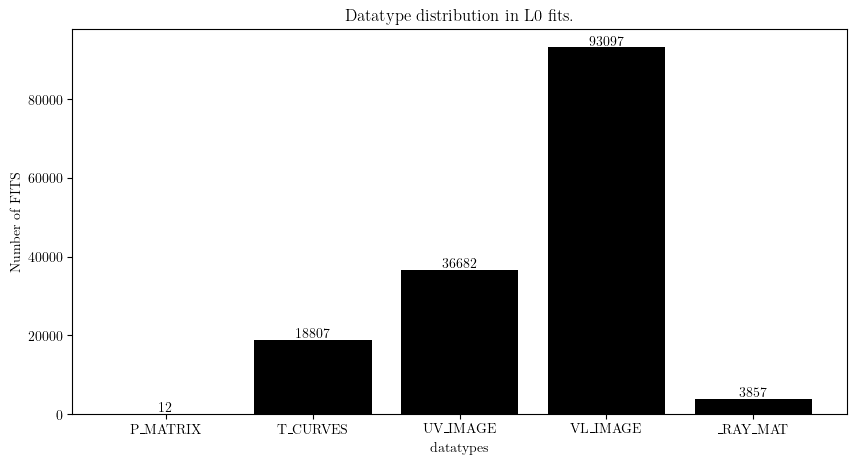

In [26]:
fig, axis = plt.subplots(1, 1, figsize = (10, 5))
a = axis.bar(labels, counts, color = "black")
axis.set_title("Datatype distribution in L0 fits.")
axis.set_ylabel("Number of FITS")
axis.set_xlabel("datatypes")
axis.bar_label(a)

Most of the FITS L0 are images in the visible light range.

#### 6.1.3. Original size of FITS

Text(0, 0.5, 'Number of files')

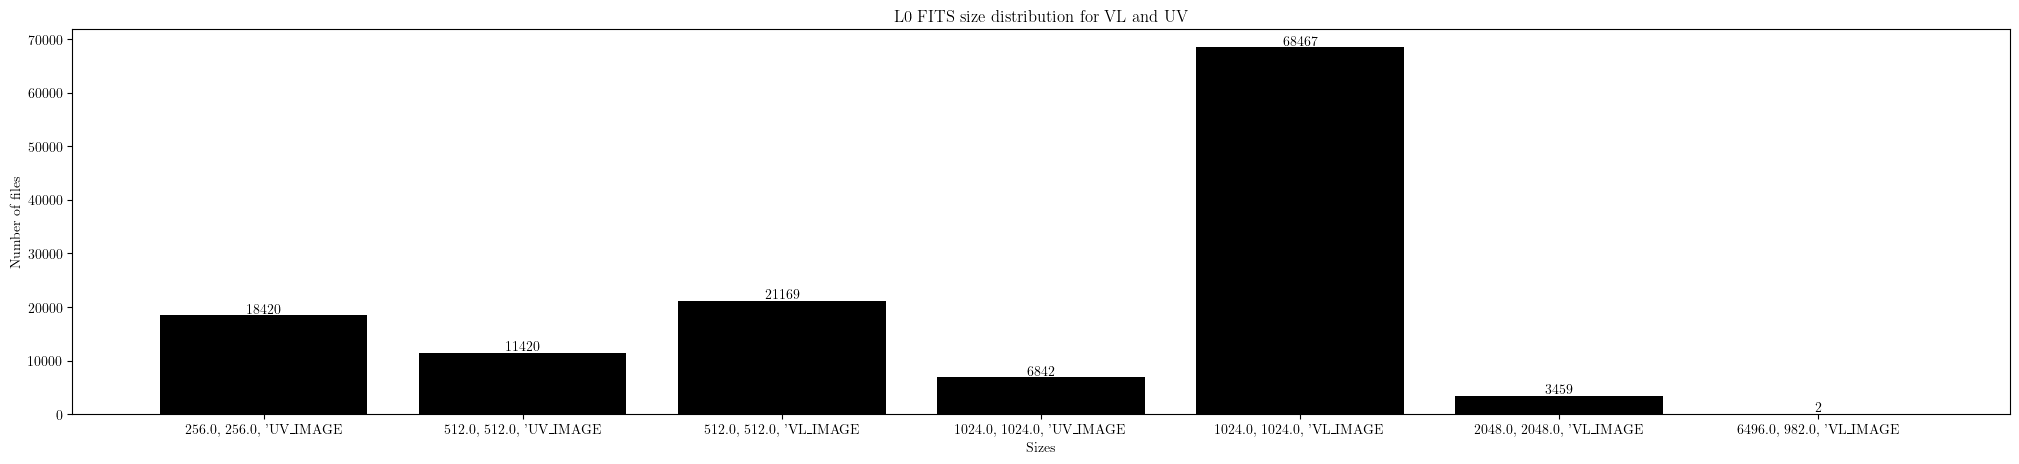

In [27]:
# Keep VL and UV images.
images_headers_l0 = headers_l0[(headers_l0["datapack"] == "UV_IMAGE") | (headers_l0["datapack"] == "VL_IMAGE")]

# Group by sizes.
sizes_l0 = images_headers_l0.groupby(["width", "height", "datapack"]).count()["id"].to_dict()
labels = [str(sizes)[1:-2] for sizes in list(sizes_l0.keys())]
fig, axis = plt.subplots(1, 1, figsize = (25, 5))
a = axis.bar(labels, list(sizes_l0.values()), color = "black")
axis.bar_label(a)
axis.set_title("L0 FITS size distribution for VL and UV")
axis.set_xlabel("Sizes")
axis.set_ylabel("Number of files")

Even though L0 FITS images have different original sizes, all the images are normalized in this way:

In [28]:
headers_l0.groupby("orig_x").count()

,id,filename,filepath,file_raw,created,date_obs_start,pubblication_time,obt_end,obt_beg,compress,...,datamin,datamax,width,height,stp,filter,ltp,url,acquisition time,datapack
orig_x,,,,,,,,,,,,,,,,,,,,,
1024.0,31653,31653,31653,31653,31653,31653,31653,31653,31653,31653,...,31653,31653,31653,31653,31653,31653,31653,31653,31653,31653
2048.0,78277,78277,78277,78277,78277,78277,78277,78277,78277,78277,...,78277,78277,78277,78277,78277,78277,78277,78277,78277,78277
6496.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


Then some images were binned in order to have an uniform size. In this case, vl images are 2048x2048 and uv are 1024x1024.

Here, we will plot images with different sizes.

**Display images VL**

In [29]:
# Select random images with different sizes.
sampleA = list(images_headers_l0[
    (images_headers_l0["datapack"] == "VL_IMAGE") 
    & (images_headers_l0["width"] == 1024.0)
    & (images_headers_l0["height"] == 1024.0)
    ].sample(1)[["url", "filename"]].reset_index(drop=True).iloc[0].to_dict().values())

sampleB = list(images_headers_l0[
    (images_headers_l0["datapack"] == "VL_IMAGE") 
    & (images_headers_l0["width"] == 512.0)
    & (images_headers_l0["height"] == 512.0)
    ].sample(1)[["url", "filename"]].reset_index(drop=True).iloc[0].to_dict().values())
sampleC = list(images_headers_l0[
    (images_headers_l0["datapack"] == "VL_IMAGE") 
    & (images_headers_l0["width"] == 2048.0)
    & (images_headers_l0["height"] == 2048.0)
    ].sample(1)[["url", "filename"]].reset_index(drop=True).iloc[0].to_dict().values())

In [30]:
# Download images.
download_fits(sampleA[0], sampleA[1], "resources/random samples VL")
download_fits(sampleB[0], sampleB[1], "resources/random samples VL")
download_fits(sampleC[0], sampleC[1], "resources/random samples VL")

HTTPError: HTTP Error 404: Not Found

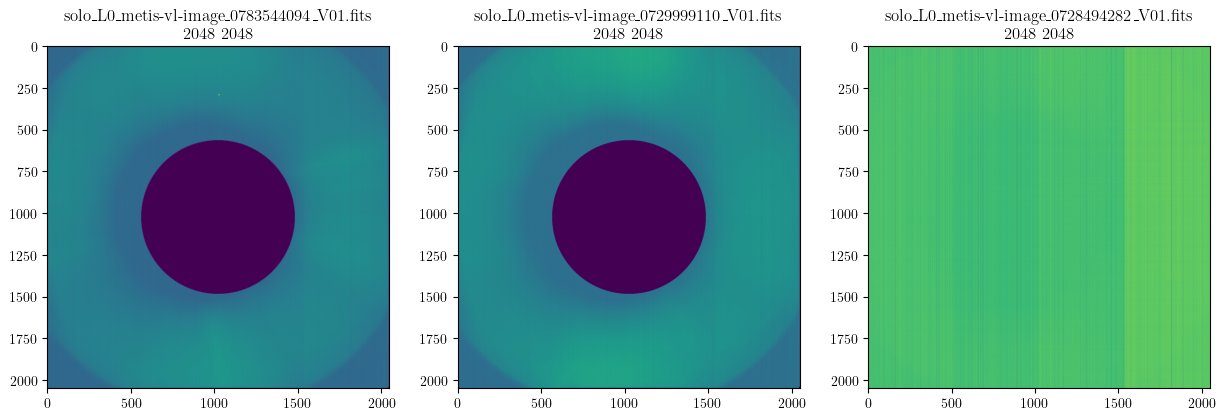

In [ ]:
fig, axis = plt.subplots(1, 3, figsize = (15,5))
folder = os.listdir("resources/random samples VL")
for idx, files in enumerate(folder):
    fits_file = fits.open(os.path.join("resources/random samples VL",files))
    axis[idx].imshow(fits_file[0].data)
    axis[idx].set_title(fits_file[0].header["FILENAME"] + "\n" + str(fits_file[0].header["NAXIS1"]) +
                        " " + str( fits_file[0].header["NAXIS2"]))
    
    if idx ==2:
        break

Despite in headers information it says images have 512, 1024 and 2048 respectively, it appears the real size is 2048 x 2048.

**Display images UV**

In [ ]:
sampleA = list(images_headers_l0[
    (images_headers_l0["datapack"] == "UV_IMAGE") 
    & (images_headers_l0["width"] == 1024.0)
    & (images_headers_l0["height"] == 1024.0)
    ].sample(1)[["url", "filename"]].reset_index(drop=True).iloc[0].to_dict().values())

sampleB = list(images_headers_l0[
    (images_headers_l0["datapack"] == "UV_IMAGE") 
    & (images_headers_l0["width"] == 512.0)
    & (images_headers_l0["height"] == 512.0)
    ].sample(1)[["url", "filename"]].reset_index(drop=True).iloc[0].to_dict().values())
sampleC = list(images_headers_l0[
    (images_headers_l0["datapack"] == "UV_IMAGE") 
    & (images_headers_l0["width"] == 256.0)
    & (images_headers_l0["height"] == 256.0)
    ].sample(1)[["url", "filename"]].reset_index(drop=True).iloc[0].to_dict().values())

In [31]:
# Download samples.
download_fits(sampleA[0], sampleA[1], "resources/random samples UV")
download_fits(sampleB[0], sampleB[1], "resources/random samples UV")
download_fits(sampleC[0], sampleC[1], "resources/random samples UV")

HTTPError: HTTP Error 404: Not Found

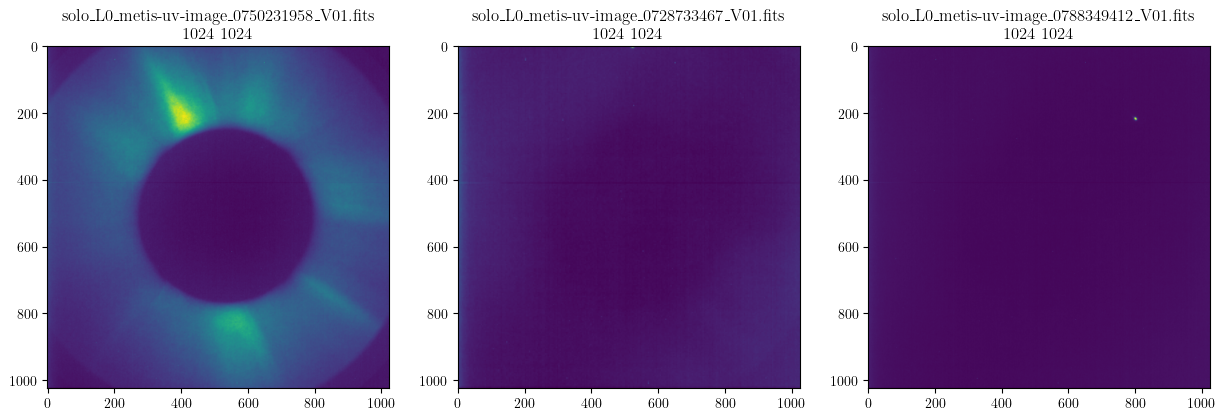

In [32]:
fig, axis = plt.subplots(1, 3, figsize = (15,5))
folder = os.listdir("resources/random samples UV")
for idx, files in enumerate(folder):
    fits_file = fits.open(os.path.join("resources/random samples UV",files))
    axis[idx].imshow(fits_file[0].data)
    axis[idx].set_title(fits_file[0].header["FILENAME"] + "\n" + str(fits_file[0].header["NAXIS1"]) +
                        " " + str( fits_file[0].header["NAXIS2"]))
    
    if idx == 2:
        break

Despite in headers information it says images have 256, 512, 1024 respectively, it appears the real size is 1024 x 1024.

Given that the sizes given in the headers of the repository does not coincides with the real ones, it is better to extract manually from each file.

#### 6.1.4. Detector integration time

Taking into account the following information:

1. **dit** -> detector integration time in ms
2. **ndit** -> number of averaged frames in VL data products.
3. **ndit1** -> number of hardware-averaged frames in UV data products and PCU acc. matrices.
4. **ndit2** -> number of averaged frames in UV data products.

The total exposure time will be: 

(detector integration time) * (number of averaged frames)

In [33]:
# Compute total exposure time, take into account that ndit is for vl images and ndit1 and ndit2 for uv images.
images_headers_l0["exposure_time"] = images_headers_l0.apply(
    lambda x: x["dit"] * x["ndit"] / 1000 if not pd.isna(x["ndit"]) else x["dit"] *x["ndit1"] * x["ndit2"] / 1000,
    axis=1
)

/tmp/ipykernel_17819/1487388755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  images_headers_l0["exposure_time"] = images_headers_l0.apply(


Text(0.5, 1.0, 'Exposure time in UV images')

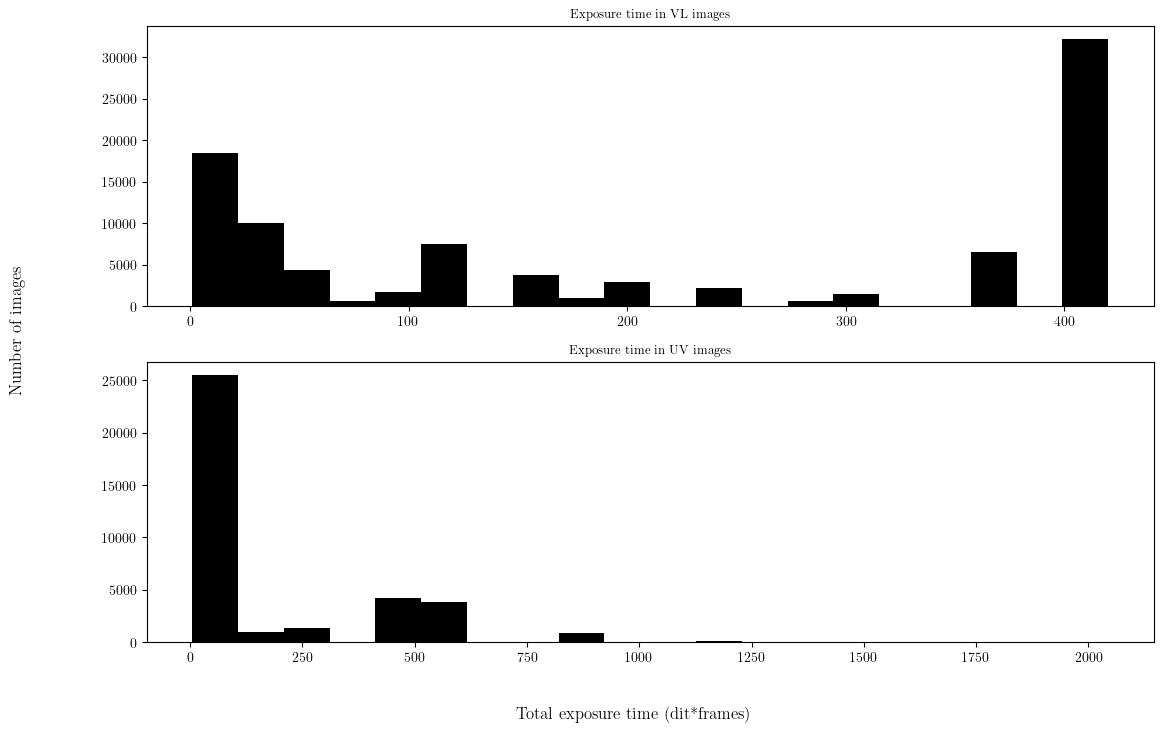

In [34]:

fig, axis = plt.subplots(2, 1, figsize = (13, 8))
fig.supxlabel("Total exposure time (dit*frames)"), fig.supylabel("Number of images")
a = axis[0].hist(images_headers_l0[images_headers_l0["datapack"] == "VL_IMAGE"]["exposure_time"].to_list(), bins =20, color ="black")
axis[0].set_title("Exposure time in VL images", fontsize = 9)
b = axis[1].hist(images_headers_l0[images_headers_l0["datapack"] == "UV_IMAGE"]["exposure_time"].to_list(), bins =20, color = "black")
axis[1].set_title("Exposure time in UV images", fontsize = 9)



Save new information.

In [35]:
images_headers_l0.to_pickle("l0_headers_refined.pkl")

In [36]:
# Generate .csv with links, stp and ltp of each L0 image in the visible light bandwidth.
images_headers_l0[images_headers_l0["datapack"] == "VL_IMAGE.raw"][["ltp", "stp", "url"]].reset_index(drop = True).to_csv("l0_fits_urls_vl.csv", index= False)
images_headers_l0[images_headers_l0["datapack"] == "UV_IMAGE.raw"][["ltp", "stp", "url"]].reset_index(drop = True).to_csv("l0_fits_urls_uv.csv", index= False)